### Import Libraries

In [34]:
import pandas as pd
import numpy as np
from numpy import triu 
import os
import re
import joblib
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


import gensim.downloader as api
from gensim.models import Word2Vec
glove_twitter_25 = api.load("glove-twitter-25")



### Read the data

In [35]:
df = pd.read_csv("../DataSets/testdata.manual.2009.06.14.csv", 
                 names=["target", "id", "date", "flags", "user", "text"])

df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


### EDA

In [36]:
df.shape

(498, 6)

In [37]:
# some data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [38]:
# check target labels count
Distribution_of_Labels = df["target"].value_counts(normalize=True, ascending=True)
Distribution_of_Labels

target
2    0.279116
0    0.355422
4    0.365462
Name: proportion, dtype: float64

In [39]:
Distribution_of_Labels.index

Index([2, 0, 4], dtype='int64', name='target')

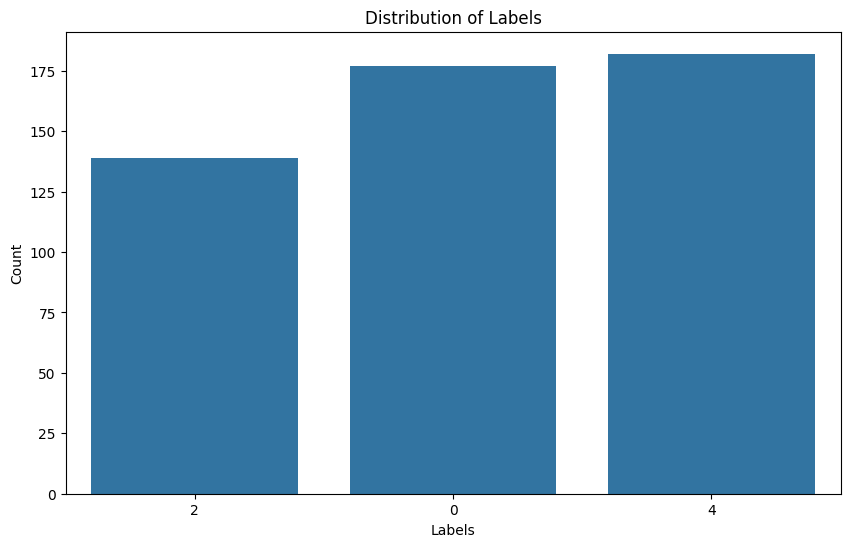

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="target", order=Distribution_of_Labels.index)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

In [41]:
# take the needed data
dataset = df[["target", "text"]]
dataset

,target,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ahhh... back in a *real* text editing environm...
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


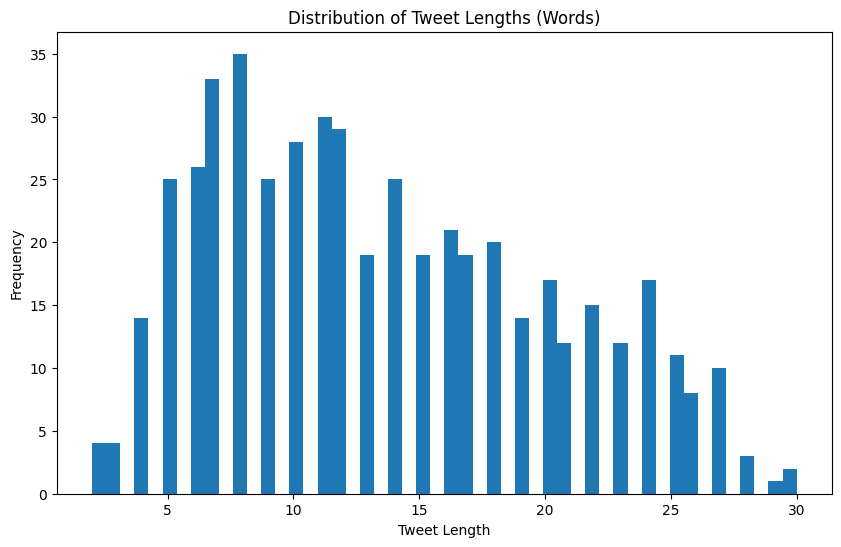

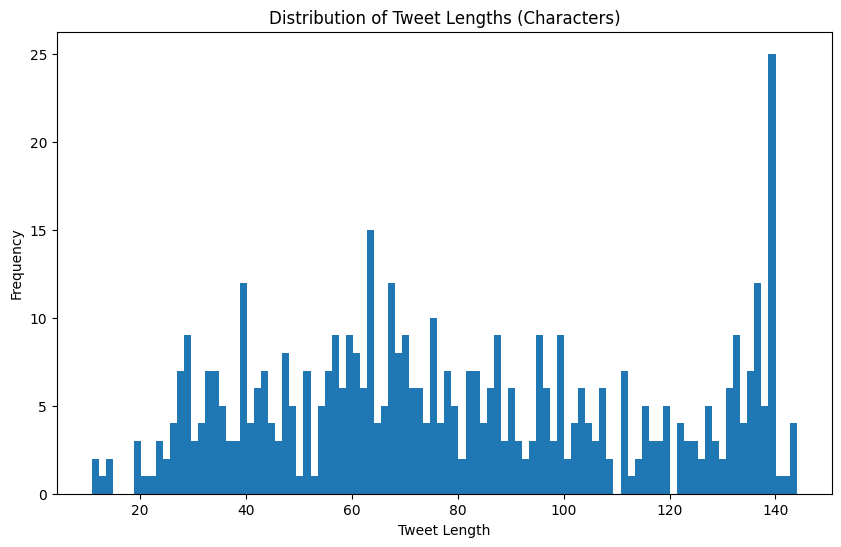

In [42]:
# show distribution for length tweets in words
length_tweets_words = [len(dataset["text"][i].split()) for i in range(len(dataset))]
plt.figure(figsize=(10, 6))
plt.hist(x=length_tweets_words, bins=50)
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths (Words)")
plt.show()



# show distribution for length tweets in characters
length_tweets_chars = dataset["text"].str.len()
plt.figure(figsize=(10, 6))
plt.hist(x=length_tweets_chars, bins=100)
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths (Characters)")
plt.show()

### Text Proccessing

In [43]:
# function to remove unwanted text patterns from tweets
def remove_pattern(input_text, pattern):
     return re.sub(pattern, '', input_text)

dataset["text"] = dataset["text"].apply(lambda x: remove_pattern(x, "@[\w]*"))

In [44]:
dataset

,target,text
0,4,I loooooooovvvvvveee my Kindle2. Not that the...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ahhh... back in a *real* text editing environm...
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [45]:
# remove hyberlinks
def remove_hyberlinks(text):
     return re.sub(r'https?://\S+', '', text)

dataset["text"] = dataset["text"].apply(lambda x: remove_hyberlinks(x))

In [46]:
# remove the repeated character
def remove_repeated_chars_more_than_2(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

dataset["text"] = dataset["text"].apply(lambda x: remove_repeated_chars_more_than_2(x))

In [47]:
dataset

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, b..."
1,4,Reading my kindle2. Love it. Lee childs is go...
2,4,"Ok, first assesment of the #kindle2 .it fuckin..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ah. back in a *real* text editing environment....
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [48]:
# Function to map emotions to there meaning
emotion_dict = {
    # 🙂 Emojis
    "😀": "grinning face",
    "😁": "beaming face with smiling eyes",
    "😂": "face with tears of joy",
    "🤣": "rolling on the floor laughing",
    "😃": "grinning face with big eyes",
    "😄": "grinning face with smiling eyes",
    "😅": "grinning face with sweat",
    "😉": "winking face",
    "😊": "smiling face with smiling eyes",
    "😍": "smiling face with heart eyes",
    "😘": "face blowing a kiss",
    "😎": "smiling face with sunglasses",
    "🥰": "smiling face with hearts",
    "😒": "unamused face",
    "😭": "loudly crying face",
    "😢": "crying face",
    "😡": "angry face",
    "😠": "angry face",
    "🤬": "face with symbols on mouth",
    "😩": "weary face",
    "😤": "face with steam from nose",
    "🤯": "exploding head",
    "😱": "screaming in fear",
    "👍": "thumbs up",
    "👎": "thumbs down",
    "❤️": "love",
    "💔": "broken heart",
    "🔥": "fire",
    "💯": "hundred points",
    "🙏": "folded hands",

    # 🙂 Emoticons
    ":)": "smiley face",
    ":-)": "smiley face",
    ":D": "grinning face",
    ":-D": "grinning face",
    ":(": "sad face",
    ":-(": "sad face",
    ":/": "unsure face",
    ":-/": "unsure face",
    ":|": "neutral face",
    ":-|": "neutral face",
    ":'(": "crying face",
    ":'-)": "crying face",
    ":P": "playful face",
    ":-P": "playful face",
    ";)": "winking face",
    ";-)": "winking face",
    ">:(": "angry face",
    "<3": "love",
    "</3": "broken heart"
}


def replace_emotions(text, emotion_dict):
    for symbol, meaning in emotion_dict.items():
        text = re.sub(re.escape(symbol), f" {meaning} ", text)
    return text

dataset["text"] = dataset["text"].apply(lambda x: replace_emotions(x, emotion_dict))

In [49]:
dataset

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, b..."
1,4,Reading my kindle2. Love it. Lee childs is go...
2,4,"Ok, first assesment of the #kindle2 .it fuckin..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ah. back in a *real* text editing environment....
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [50]:
# remove punctuations and number 
def remove_punc(text):
     text = re.sub(r'\d+', '', text)
     text = re.sub(r'[^\w\s]', '', text)
     text = re.sub(r'\s+', ' ', text).strip()
     return text

dataset["text"] = dataset["text"].apply(remove_punc) 
dataset

,target,text
0,4,I love my Kindle Not that the DX is cool but t...
1,4,Reading my kindle Love it Lee childs is good read
2,4,Ok first assesment of the kindle it fucking rocks
3,4,Youll love your Kindle Ive had mine for a few ...
4,4,Fair enough But i have the Kindle and I think ...
...,...,...
493,2,Ask Programming LaTeX or InDesign submitted by...
494,0,On that note I hate Word I hate Pages I hate L...
495,4,Ah back in a real text editing environment I l...
496,0,Trouble in Iran I see Hmm Iran Iran so far awa...


In [51]:
# Function to tokenization and lemmatization
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

# tokenization + POS tagging + lemmatization
def tokeniz_lemm(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return " ".join(lemmatized)

dataset["text"] = dataset["text"].apply(lambda x: tokeniz_lemm(x))
dataset

,target,text
0,4,I love my Kindle Not that the DX be cool but t...
1,4,Reading my kindle Love it Lee child be good read
2,4,Ok first assesment of the kindle it fuck rock
3,4,Youll love your Kindle Ive have mine for a few...
4,4,Fair enough But i have the Kindle and I think ...
...,...,...
493,2,Ask Programming LaTeX or InDesign submit by ca...
494,0,On that note I hate Word I hate Pages I hate L...
495,4,Ah back in a real text edit environment I lt L...
496,0,Trouble in Iran I see Hmm Iran Iran so far awa...


#### `Wordcloud figure`

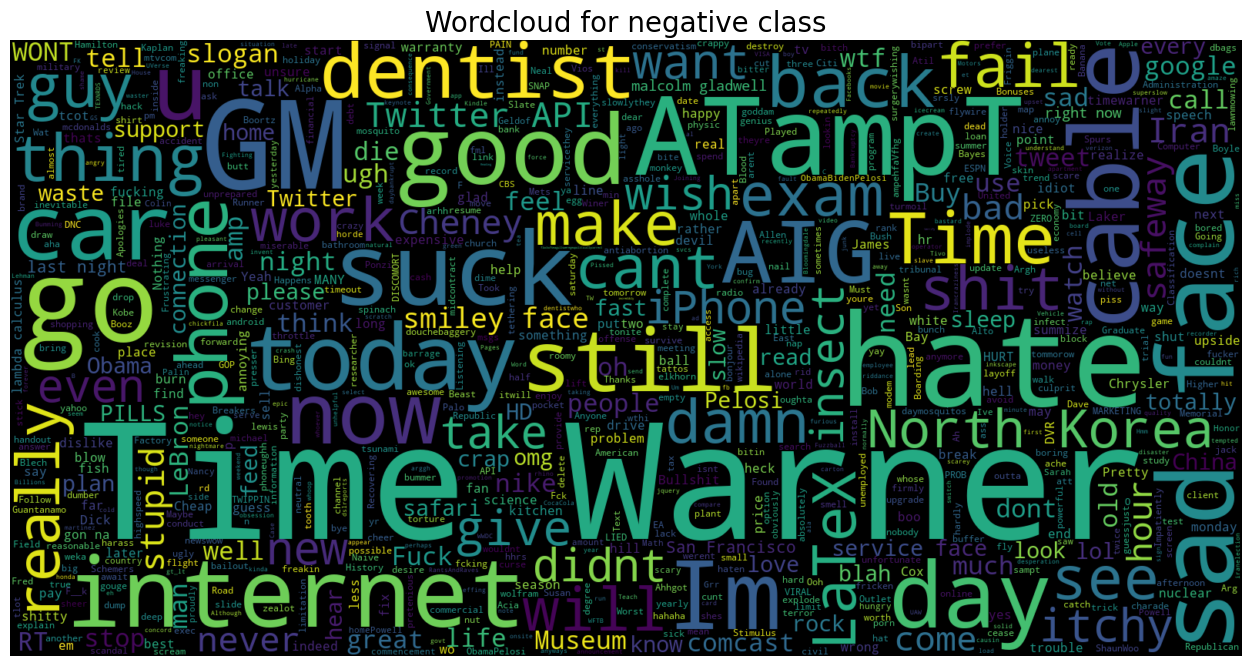

In [19]:
# wordcloud for negative class
plt.figure(figsize=(20,8))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(dataset[dataset["target"] == 0]["text"].astype(str)))
plt.title("Wordcloud for negative class", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

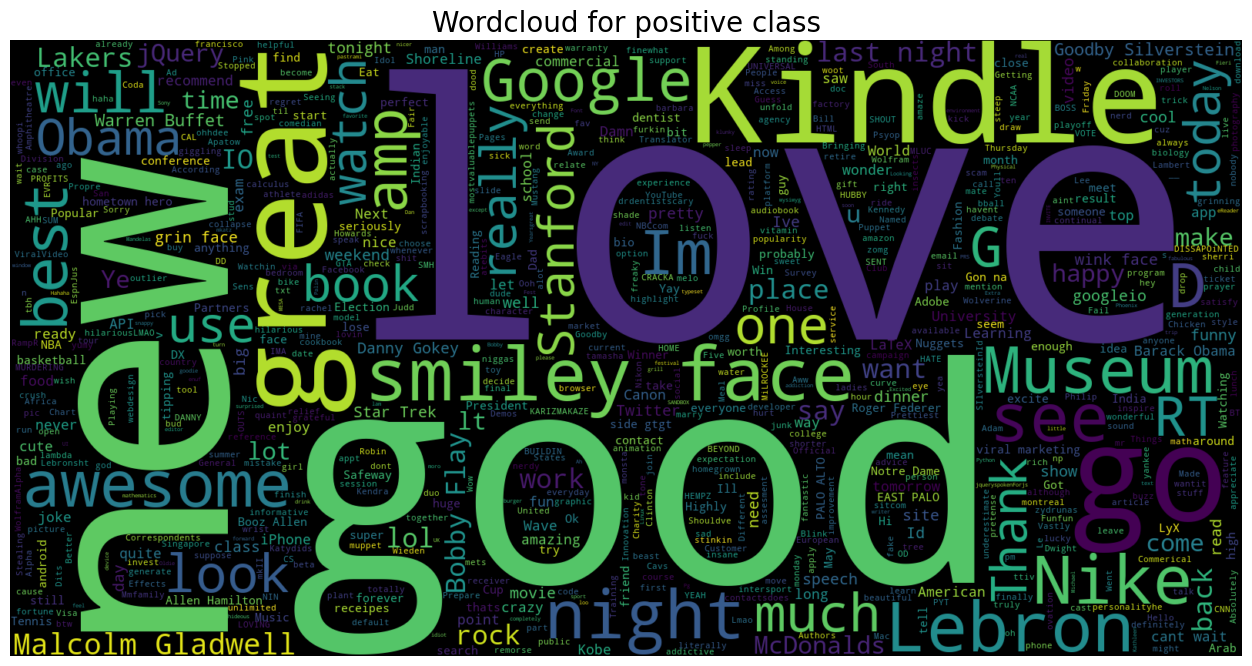

In [20]:
# wordcloud for positive class
plt.figure(figsize=(20,8))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(dataset[dataset["target"] == 4]["text"].astype(str)))
plt.title("Wordcloud for positive class", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

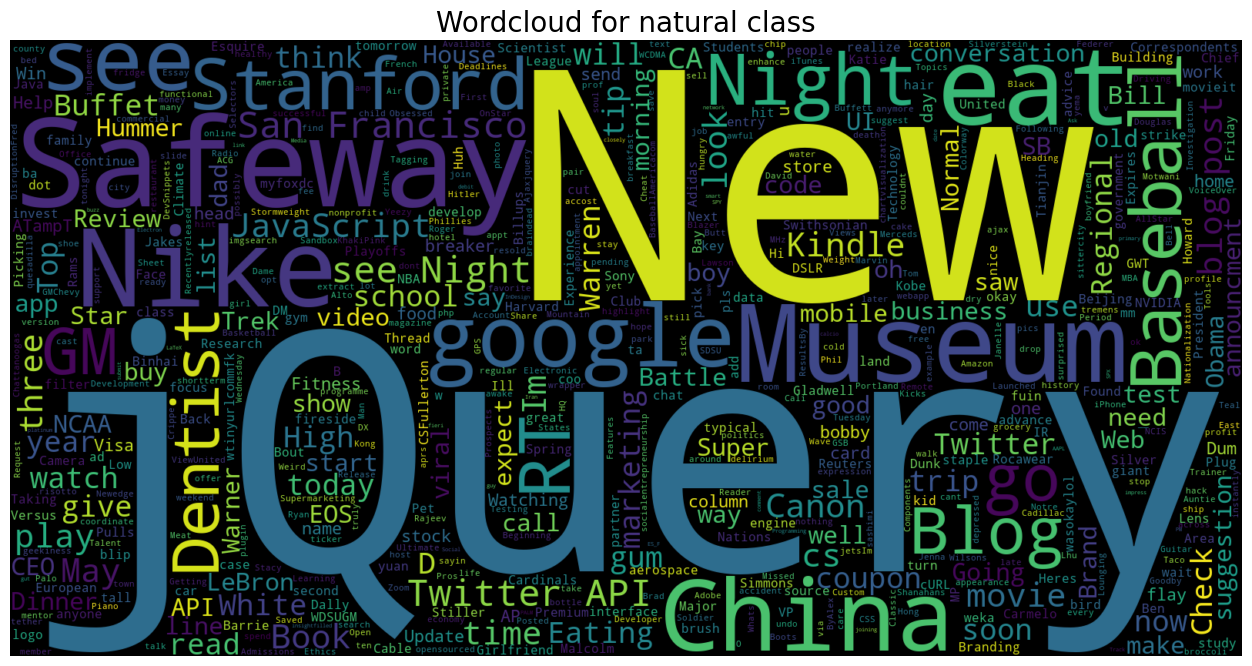

In [21]:
# wordcloud for natural class
plt.figure(figsize=(20,8))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(dataset[dataset["target"] == 2]["text"].astype(str)))
plt.title("Wordcloud for natural class", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Text Vectorization

###### BOW

In [22]:
# make victorization using BOW
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, ngram_range=(1, 3))
X = bow.fit_transform(dataset["text"])

victoried_data_bow = pd.DataFrame(data=X.toarray(), columns=bow.get_feature_names_out())
victoried_data_bow

,about,after,again,aig,all,amp,an,and,and love,any,...,will,wish,with,with the,work,world,year,yes,you,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### TF-IDF

In [23]:
# make victorization using tf-idf
tf_idf = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, ngram_range=(1, 3))
X = tf_idf.fit_transform(dataset["text"])

In [24]:
victoried_data = pd.DataFrame(data=X.toarray(), columns=tf_idf.get_feature_names_out())
victoried_data

,about,after,again,aig,all,amp,an,and,and love,any,...,will,wish,with,with the,work,world,year,yes,you,your
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.139108,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.234396
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.197447,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
494,0.0,0.0,0.0,0.0,0.186412,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1468,0.000000
495,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
496,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000


###### Word2Vec

In [25]:
sentences = [text.split() for text in dataset["text"]]
word2vec = Word2Vec(sentences,
                    vector_size=300,
                    window=5,
                    min_count=1,
                    workers=-1,
                    sg=1,
                    epochs=100)


def sentences_to_vectors(sentences: str):
     words = sentences.lower().split()
     vectors = [word2vec.wv[word] for word in words if word in word2vec.wv]
     if len(vectors) == 0:
         return np.zeros(word2vec.vector_size)
     return np.mean(vectors, axis=0)
 
# apply
word2vec_vectors = np.array([sentences_to_vectors(sentence) for sentence in dataset["text"]])

word2vec_vectors

array([[-5.33434271e-04,  5.83594374e-04,  2.47487478e-05, ...,
         6.48635207e-04,  1.23398867e-03, -6.10954128e-04],
       [-6.53714058e-04,  8.68439325e-04, -8.66615155e-04, ...,
        -5.61243389e-04, -1.38333984e-04,  1.35787224e-04],
       [-4.79533133e-04,  5.96608152e-05,  1.17682363e-03, ...,
         1.43453421e-04,  1.93916203e-04,  9.13999043e-04],
       ...,
       [ 1.22867015e-04,  6.81154197e-05, -5.35347150e-04, ...,
        -4.66114841e-04,  1.14807254e-03, -9.58854973e-04],
       [-8.41130037e-04,  3.48981994e-05, -4.54173103e-04, ...,
         4.27367602e-04, -1.16218755e-04, -8.09702789e-04],
       [-3.18969933e-06, -4.06564577e-05,  4.66522935e-04, ...,
        -1.33026420e-04,  9.79840057e-04, -5.51064149e-04]], dtype=float32)

###### Glove twitter 25 dim

In [26]:
def sentence_to_vector_glove(sentence: str):
    words = sentence.split()
    vector_words = [glove_twitter_25[word] for word in words if word in glove_twitter_25]
    if len(vector_words) == 0:
        return np.zeros(25)  
    return np.mean(vector_words, axis=0)  

glove_twitter_vectors = np.array([sentence_to_vector_glove(sentence) for sentence in dataset["text"]])
glove_twitter_vectors

array([[-0.20938151,  0.18982056,  0.02511474, ..., -0.0252858 ,
         0.07890064, -0.23676465],
       [-0.14189859,  0.44111285,  0.08946357, ..., -0.25957429,
         0.28181714, -0.17337786],
       [ 0.19423935,  0.15051712,  0.19566154, ...,  0.037638  ,
        -0.16892076,  0.06325214],
       ...,
       [-0.00989012,  0.19204551, -0.2151325 , ...,  0.14070609,
        -0.02511625, -0.26376912],
       [-0.20016201,  0.13353999,  0.1923774 , ...,  0.241115  ,
         0.26711801, -0.13538   ],
       [-0.11255639,  0.12764515,  0.16509758, ..., -0.05571191,
        -0.10382434, -0.33365574]])

##### Split the data


In [27]:
# some maping on the target variable

target_map_var = {
     0:0,
     4:1,
     2:2
}

dataset["target"] = dataset["target"].map(target_map_var)
dataset["target"].value_counts()

target
1    182
0    177
2    139
Name: count, dtype: int64

In [28]:
# split the data train and test
X = dataset.drop('target', axis=1)
y = dataset['target']

X_train, X_test_origin, y_train, y_test_origin = train_test_split(X, 
                                                                 y, 
                                                                 test_size=0.2, 
                                                                 random_state=42, 
                                                                 shuffle=True, 
                                                                 stratify=y
                                                                 )



In [29]:
# function for data vectorizing & resampling & splitting
def prepare_data(method: str):
     if method == "bow":
          X = victoried_data_bow
     elif method == "tfidf":
          X = victoried_data
     elif method == "word2vec":
          X = word2vec_vectors
     elif method == "glove":
          X = glove_twitter_vectors
     else:
          raise ValueError("Invalid method. Choose 'tfidf' or 'word2vec'.")
     
     over = SMOTE(random_state=42)
     y = dataset["target"]
     X_new, y_new = over.fit_resample(X, y)
     
     # split 
     X_train, X_test, y_train, y_test = train_test_split(
          X_new, y_new, test_size=0.2, random_state=42,
          stratify=y_new
     )
     return X_train, X_test, y_train, y_test

### Building models

In [30]:
# make prediction 
def svc_model(method: str):
     X_train, X_test, y_train, y_test = prepare_data(method=method)
     model = SVC(kernel="rbf", gamma=0.15, random_state=42, C=0.95)
     model.fit(X_train, y_train)
     y_pred_train = model.predict(X_train)
     y_pred = model.predict(X_test)
     acc_train = accuracy_score(y_train, y_pred_train)
     acc_test = accuracy_score(y_test, y_pred)
     return model, acc_train, acc_test

svm_model_bow, acc_train, acc_test = svc_model(method="bow")
print("Using Bag of Words Vectorization ✈")
print(f"Accracy on training set {acc_train}")
print(f"Accracy on test set {acc_test}")
print("--"*10)

svm_model_tfidf, acc_train, acc_test = svc_model(method="tfidf")
print("Using TF-IDF Vectorization ✈")
print(f"Accuracy on training set: {acc_train}")
print(f"Accuracy on test set: {acc_test}")
print("--"*10)

svm_model_word2vec, acc_train, acc_test = svc_model(method="word2vec")
print("Using Word2Vec Vectorization ✈")
print(f"Accuracy on training set: {acc_train}")
print(f"Accuracy on test set: {acc_test}")
print("--"*10)
svm_model_glove, acc_train, acc_test = svc_model(method="glove")
print("Using GloVe Vectorization ✈")
print(f"Accuracy on training set: {acc_train}")  
print(f"Accuracy on test set: {acc_test}")


Using Bag of Words Vectorization ✈
Accracy on training set 0.9288990825688074
Accracy on test set 0.7454545454545455
--------------------
Using TF-IDF Vectorization ✈
Accuracy on training set: 0.8371559633027523
Accuracy on test set: 0.7454545454545455
--------------------
Using Word2Vec Vectorization ✈
Accuracy on training set: 0.3348623853211009
Accuracy on test set: 0.32727272727272727
--------------------
Using GloVe Vectorization ✈
Accuracy on training set: 0.7522935779816514
Accuracy on test set: 0.6454545454545455


# `Make artifacts folder`

In [31]:
ARTIFACTS_FOLDER = os.path.join(os.getcwd(), "..", "artifacts")
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)


In [ ]:
# DUMP the victorizer model
joblib.dump(tf_idf, filename=os.path.join(ARTIFACTS_FOLDER, "tf-idf.pkl"))
joblib.dump(bow, filename=os.path.join(ARTIFACTS_FOLDER, "bow.pkl"))

# Save the word2vec model
word2vec.save(os.path.join(ARTIFACTS_FOLDER, "word2vec.model"))


In [33]:
# dumb models
svm_bow = joblib.dump(svm_model_bow, os.path.join(ARTIFACTS_FOLDER, "svm_model_bow.pkl"))
svm_tfidf = joblib.dump(svm_model_tfidf, os.path.join(ARTIFACTS_FOLDER, "svm_model_tfidf.pkl"))
svm_glove = joblib.dump(svm_model_glove, os.path.join(ARTIFACTS_FOLDER, "svm_model_glove.pkl"))

-------------

#                                    END

--------------